In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from config import *

In [2]:
record_time = np.zeros(int(T/PERIOD))
for t in range(1, T+1):
    if t % PERIOD == 0:
        record_time[int(t/PERIOD)-1] = t

In [3]:
def record(old_array, record_time, to_be_record, baseline, n, dataset, distribution, prob):
    for t,v in zip(record_time, to_be_record):
        if old_array is None:
            old_array = np.array([baseline, n, dataset, distribution, prob, t, v])
        else:
            old_array = np.vstack((old_array, np.array([baseline, n, dataset, distribution, prob, t, v])))
    return old_array

In [4]:
all_data = None
for BASELINE in BASELINES:
    for N in Ns:
        for DATASET in DATASETS:
            for DISTRIBUTION in DISTRIBUTIONS:
                if BASELINE == "MOTS":
                    if DISTRIBUTION in ["Gamma", "Poisson"]:
                        continue
                if BASELINE in ["TSGreedy", "ExpTS_plus"]:
                    for PROB in PROBS_fn(N):
                        data = np.load("./results/{}-{}-{}-{}-{}.npy".format(BASELINE, N, DATASET, DISTRIBUTION, round(PROB, 2)))
                        all_data = record(all_data, record_time, data, BASELINE, N, DATASET, DISTRIBUTION, PROB)
                else:
                    data = np.load("./results/{}-{}-{}-{}-{}.npy".format(BASELINE, N, DATASET, DISTRIBUTION, 1.0))
                    all_data = record(all_data, record_time, data, BASELINE, N, DATASET, DISTRIBUTION, 1.0)

In [7]:
eval_path = "./results/results.xlsx"
col = np.array(["baseline", "n", "dataset", "distribution", "prob", "t", "eval"])
df = pd.DataFrame(all_data, columns=col)
df.to_excel(eval_path)

In [4]:
# read results
eval_path = "./results/results.xlsx"
df = pd.read_excel(eval_path, index_col=0, dtype={"baseline":str, "n":int, "dataset":str, "distribution":str, "prob":float, "t":int, "eval":float})

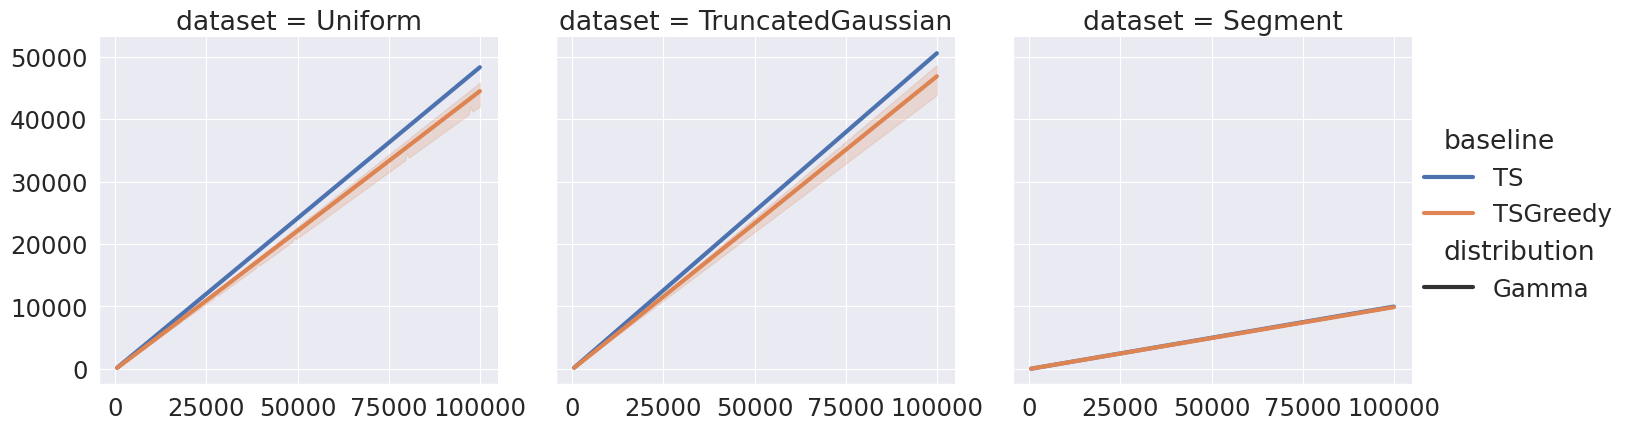

In [12]:
# "baseline", "n", "dataset", "distribution", "prob", "t", "eval"
df_eval = df[(df.n==50)&(df.distribution=="Gamma")]
pal20c = sns.color_palette('tab20c', 20)
sns.set_theme()
sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 3}) 
fg = sns.relplot(data=df_eval, x="t", y="eval", col="dataset", hue="baseline", style = "distribution", kind="line", legend="full")
# fg = sns.lineplot(data=df_eval, x="iter", y="eval", hue="dataset", hue_order=["mnist","fmnist","cifar10"], style="method", style_order=["Random", "DVI", "TimeVis"], legend="full")
# sns.move_legend(fg, "lower center", bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=False)
fg.set(xlabel='', ylabel='')

fg.figure.savefig(
    "./results/n_50.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.0,
    transparent=True,
)

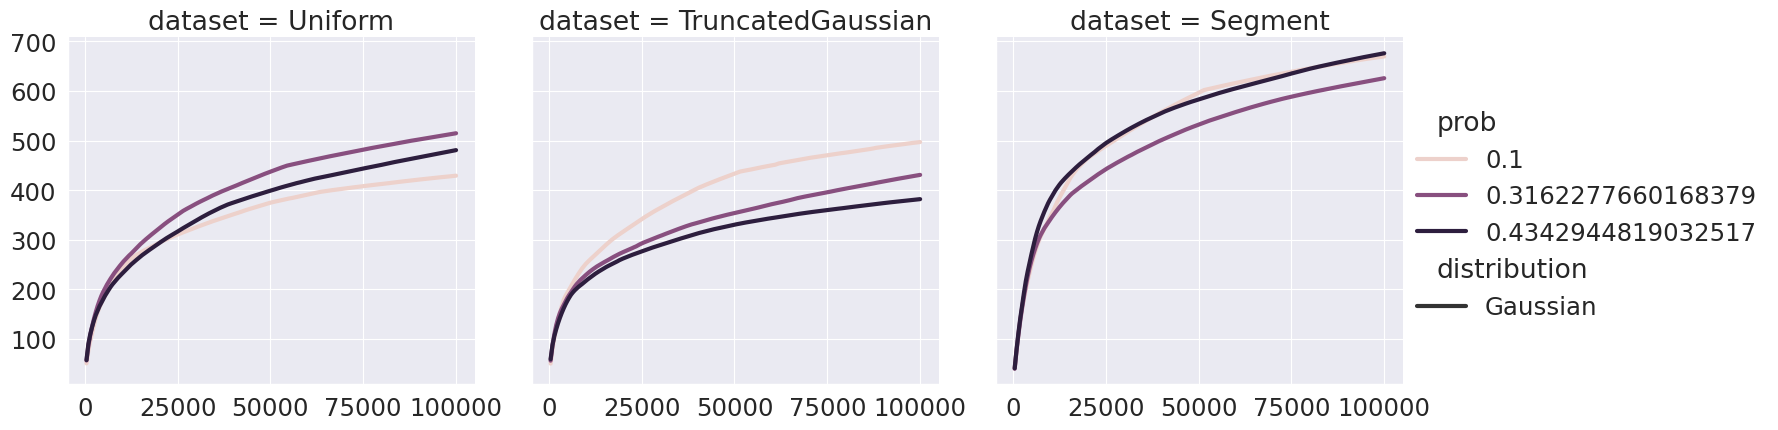

In [6]:
# "baseline", "n", "dataset", "distribution", "prob", "t", "eval"
df_eval = df[(df.n==10)&(df.baseline=="TSGreedy")&(df.distribution=="Gaussian")]
pal20c = sns.color_palette('tab20c', 20)
sns.set_theme()
sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 3}) 
fg = sns.relplot(data=df_eval, x="t", y="eval", col="dataset", hue="prob", style = "distribution", kind="line", legend="full")
# fg = sns.lineplot(data=df_eval, x="iter", y="eval", hue="dataset", hue_order=["mnist","fmnist","cifar10"], style="method", style_order=["Random", "DVI", "TimeVis"], legend="full")
# sns.move_legend(fg, "lower center", bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=False)
fg.set(xlabel='', ylabel='')

fg.figure.savefig(
    "./results/n_10_TSGreedy.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.0,
    transparent=True,
)